<a href="https://colab.research.google.com/github/BehrozKhawar-23005633/MultiClass-Lung-Disease-Detection/blob/main/Pneumonia_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Import Libraries**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import random
import shutil
from tensorflow.keras.preprocessing.image import img_to_array, load_img, save_img

# **Mount Google Drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Verify dataset location**

In [3]:
!ls "/content/drive/MyDrive/Colab Notebooks/COVID-19_Radiography_Dataset"

 COVID		       Lung_Opacity.metadata.xlsx   README.md.txt
 COVID.metadata.xlsx   Normal			   'Viral Pneumonia'
 Lung_Opacity	       Normal.metadata.xlsx	   'Viral Pneumonia.metadata.xlsx'


# **Count Images in Each Class**
Let's verify the number of images in each category (COVID, Viral Pneumonia, Normal, Lung_Opacity) to check for imbalanced data.

In [4]:
# Define dataset path
dataset_path = "/content/drive/MyDrive/Colab Notebooks/COVID-19_Radiography_Dataset"

# Count images in each category (inside 'images' subfolder)
categories = ["COVID", "Viral Pneumonia", "Normal", "Lung_Opacity"]
for category in categories:
    image_folder = os.path.join(dataset_path, category, "images")  # Access 'images' subfolder
    if os.path.exists(image_folder):  # Ensure the folder exists
        num_images = len(os.listdir(image_folder))
        print(f"Category: {category}, Image Count: {num_images}")
    else:
        print(f"Warning: No 'images' folder found in {category}")

Category: COVID, Image Count: 3616
Category: Viral Pneumonia, Image Count: 3600
Category: Normal, Image Count: 1345
Category: Lung_Opacity, Image Count: 6012


# **Visualizing Dataset Distribution Through Bar Plot**
Let's plot the class distribution to see the imbalance clearly.

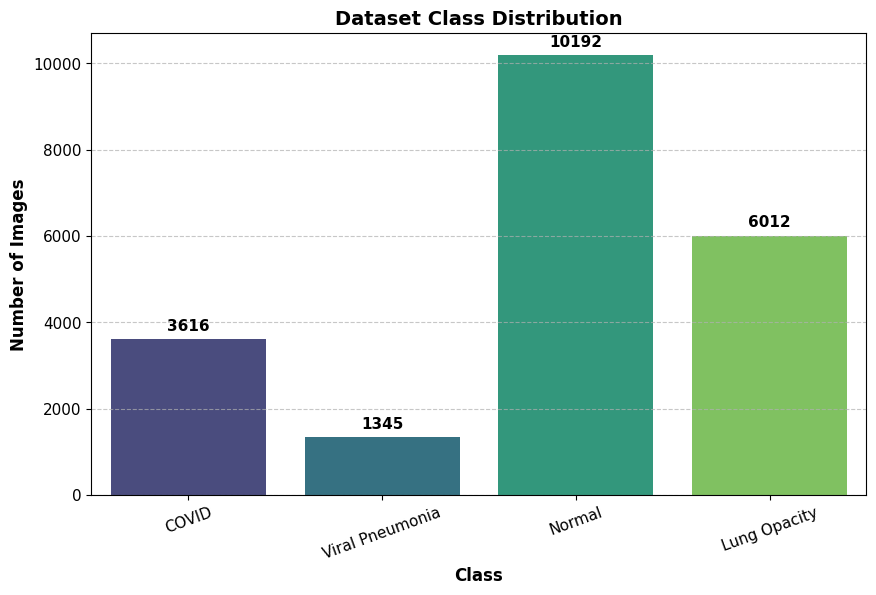

In [5]:
def plot_class_distribution(categories, image_counts, save_path="class_distribution.png"):
    """
    Plots and saves the dataset class distribution bar chart.
    """
    plt.figure(figsize=(10, 6))

    sns.barplot(x=categories, y=image_counts, hue=categories, palette="viridis", legend=False)

    # Enhancing visualization
    plt.xlabel("Class", fontsize=12, fontweight='bold')
    plt.ylabel("Number of Images", fontsize=12, fontweight='bold')
    plt.title("Dataset Class Distribution", fontsize=14, fontweight='bold')
    plt.xticks(rotation=20, fontsize=11)
    plt.yticks(fontsize=11)

    # Display exact count values on top of bars
    for index, value in enumerate(image_counts):
        plt.text(index, value + 200, str(value), ha='center', fontsize=11, fontweight='bold')

    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Save and show the plot
    plt.savefig(save_path, bbox_inches="tight", dpi=300)
    plt.show()

# Data
categories = ["COVID", "Viral Pneumonia", "Normal", "Lung Opacity"]
image_counts = [3616, 1345, 10192, 6012]

# Generate and save plot
plot_class_distribution(categories, image_counts)

# **Data Balance Techniques**

1.   Under Sampling
2.   Over Sampling
3.   Data Augmentation



**1. Under Sampling**

* Reduces the number of images in a Normal images  by randomly selecting a subset to match with Viral Pneumonia images count


In [6]:
def undersample_class(class_path, target_count):
    images_folder = os.path.join(class_path, "images")
    all_images = os.listdir(images_folder)

    if len(all_images) > target_count:
        # Randomly select images to keep
        selected_images = random.sample(all_images, target_count)

        # Move unselected images to a backup folder
        backup_folder = os.path.join(class_path, "backup_images")
        os.makedirs(backup_folder, exist_ok=True)

        for img in all_images:
            if img not in selected_images:
                shutil.move(os.path.join(images_folder, img), os.path.join(backup_folder, img))

        print(f"Undersampling Complete: Retained {target_count} images in {class_path}")

# Define dataset path
dataset_path = "/content/drive/MyDrive/Colab Notebooks/COVID-19_Radiography_Dataset"

# Apply undersampling to Normal class
undersample_class(os.path.join(dataset_path, "Normal"), target_count=1345)


**Undersampling Bar Plot**

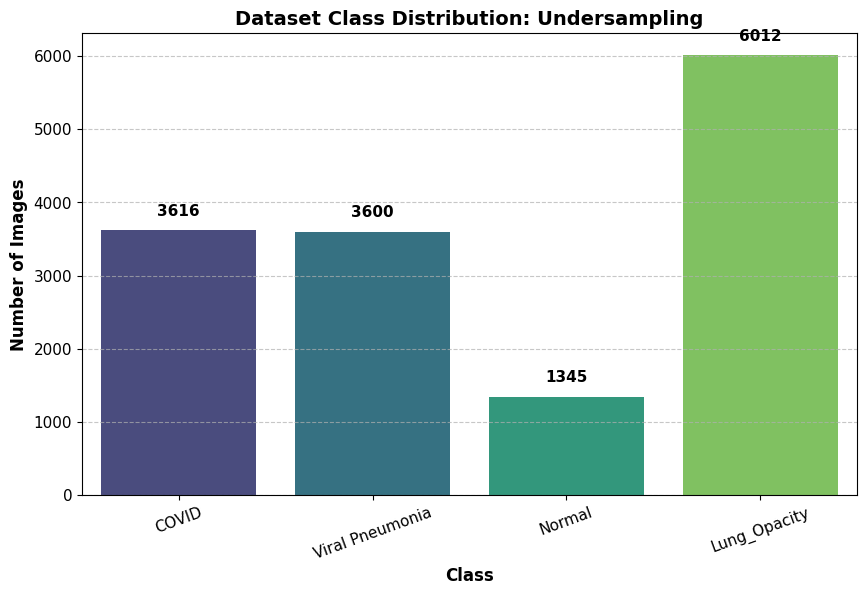

In [7]:
def count_images(dataset_path, categories):
    """
    Counts the number of images in each class after undersampling.
    """
    image_counts = []
    for category in categories:
        image_folder = os.path.join(dataset_path, category, "images")
        if os.path.exists(image_folder):
            num_images = len(os.listdir(image_folder))
            image_counts.append(num_images)
        else:
            image_counts.append(0)  # In case the folder is missing
            print(f"Warning: No 'images' folder found in {category}")
    return image_counts

def plot_class_distribution(categories, image_counts, save_path="updated_class_distribution.png"):
    """
    Plots and saves the updated dataset class distribution bar chart.
    """
    plt.figure(figsize=(10, 6))

    sns.barplot(x=categories, y=image_counts, hue=categories, palette="viridis", legend=False)

    # Enhancing visualization
    plt.xlabel("Class", fontsize=12, fontweight='bold')
    plt.ylabel("Number of Images", fontsize=12, fontweight='bold')
    plt.title("Dataset Class Distribution: Undersampling", fontsize=14, fontweight='bold')
    plt.xticks(rotation=20, fontsize=11)
    plt.yticks(fontsize=11)

    # Display exact count values on top of bars
    for index, value in enumerate(image_counts):
        plt.text(index, value + 200, str(value), ha='center', fontsize=11, fontweight='bold')

    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Save and show the plot
    plt.savefig(save_path, bbox_inches="tight", dpi=300)
    plt.show()

# Define dataset path
dataset_path = "/content/drive/MyDrive/Colab Notebooks/COVID-19_Radiography_Dataset"
categories = ["COVID", "Viral Pneumonia", "Normal", "Lung_Opacity"]

# Count updated images
updated_image_counts = count_images(dataset_path, categories)

# Generate and save the updated plot
plot_class_distribution(categories, updated_image_counts)

**2. OverSampling**

* Increases the number of images in Viral Penumenia class by duplicating existing images to match Closet Class i-e Covid Samples Images





In [8]:
def oversample_class(class_path, target_count):
    images_folder = os.path.join(class_path, "images")
    all_images = os.listdir(images_folder)
    current_count = len(all_images)

    if current_count < target_count:
        num_to_add = target_count - current_count
        print(f"Oversampling: Need to add {num_to_add} images to {class_path}")

        for i in range(num_to_add):
            img_to_copy = random.choice(all_images)  # Randomly pick an image
            new_img_name = f"copy_{i}_{img_to_copy}"  # Rename the duplicate
            shutil.copy(os.path.join(images_folder, img_to_copy),
                        os.path.join(images_folder, new_img_name))

        print(f"Oversampling Complete: {target_count} images now in {class_path}")
    else:
        print(f"Oversampling Not Needed: {class_path} already has sufficient images")

# Define dataset path
dataset_path = "/content/drive/MyDrive/Colab Notebooks/COVID-19_Radiography_Dataset"

# Apply oversampling to Viral Pneumonia class (match COVID count of ~3,600)
oversample_class(os.path.join(dataset_path, "Viral Pneumonia"), target_count=3600)


Oversampling Not Needed: /content/drive/MyDrive/Colab Notebooks/COVID-19_Radiography_Dataset/Viral Pneumonia already has sufficient images


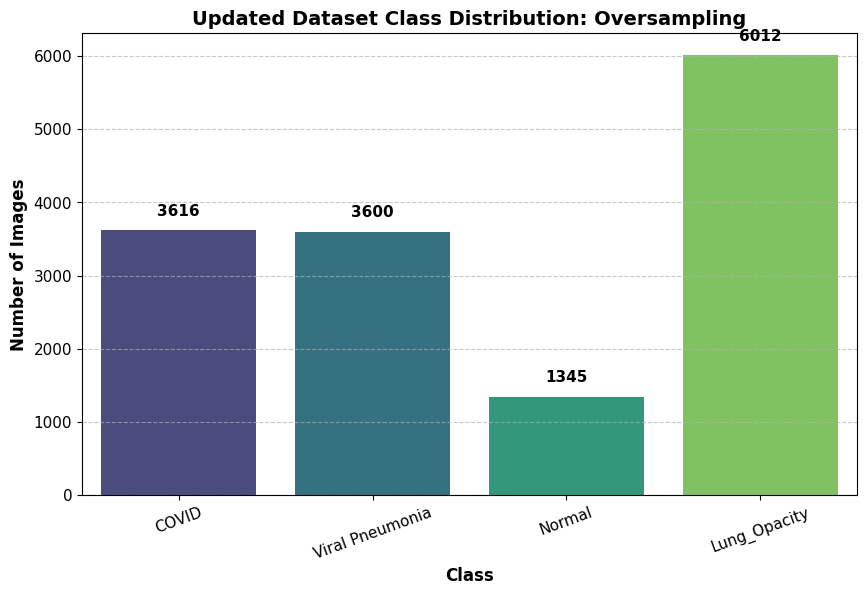

In [9]:
def count_images(dataset_path, categories):
    """
    Counts the number of images in each class after oversampling.
    """
    image_counts = []
    for category in categories:
        image_folder = os.path.join(dataset_path, category, "images")
        if os.path.exists(image_folder):
            num_images = len(os.listdir(image_folder))
            image_counts.append(num_images)
        else:
            image_counts.append(0)  # In case the folder is missing
            print(f"Warning: No 'images' folder found in {category}")
    return image_counts

def plot_class_distribution(categories, image_counts, save_path="updated_class_distribution.png"):
    """
    Plots and saves the updated dataset class distribution bar chart.
    """
    plt.figure(figsize=(10, 6))

    sns.barplot(x=categories, y=image_counts, hue=categories, palette="viridis", legend=False)

    # Enhancing visualization
    plt.xlabel("Class", fontsize=12, fontweight='bold')
    plt.ylabel("Number of Images", fontsize=12, fontweight='bold')
    plt.title("Updated Dataset Class Distribution: Oversampling", fontsize=14, fontweight='bold')
    plt.xticks(rotation=20, fontsize=11)
    plt.yticks(fontsize=11)

    # Display exact count values on top of bars
    for index, value in enumerate(image_counts):
        plt.text(index, value + 200, str(value), ha='center', fontsize=11, fontweight='bold')

    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Save and show the plot
    plt.savefig(save_path, bbox_inches="tight", dpi=300)
    plt.show()

# Define dataset path
dataset_path = "/content/drive/MyDrive/Colab Notebooks/COVID-19_Radiography_Dataset"
categories = ["COVID", "Viral Pneumonia", "Normal", "Lung_Opacity"]

# Count updated images
updated_image_counts = count_images(dataset_path, categories)

# Generate and save the updated plot
plot_class_distribution(categories, updated_image_counts)

## **Data Augmentation**

*   We will test augmentation techniques here and decide which are gonna be use in our learning models



**Step 1: Rotation Augmentation**

*    Applies random rotation to an image.



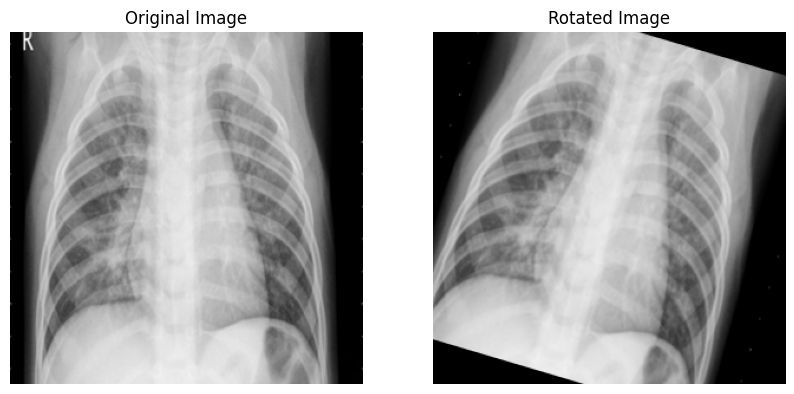

In [10]:
def apply_rotation(image_path, rotation_range=30):

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    height, width = image.shape[:2]

    # Choose a random rotation angle
    angle = random.uniform(-rotation_range, rotation_range)

    # Compute rotation matrix
    M = cv2.getRotationMatrix2D((width // 2, height // 2), angle, 1)
    rotated_image = cv2.warpAffine(image, M, (width, height))

    return rotated_image

# Select a random image from the dataset
image_folder = "/content/drive/MyDrive/Colab Notebooks/COVID-19_Radiography_Dataset/Viral Pneumonia/images"
sample_image = random.choice(os.listdir(image_folder))
sample_image_path = os.path.join(image_folder, sample_image)

# Apply Rotation
rotated_image = apply_rotation(sample_image_path)

# Plot Original vs Rotated Image
original_image = cv2.imread(sample_image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(rotated_image)
plt.title("Rotated Image")
plt.axis("off")

plt.savefig("rotation_augmentation.png", dpi=300, bbox_inches="tight")
plt.show()


**Step 2: Flipping Augmentation (Horizontal + Vertical)**

*   Applies both horizontal and vertical flip to an image.



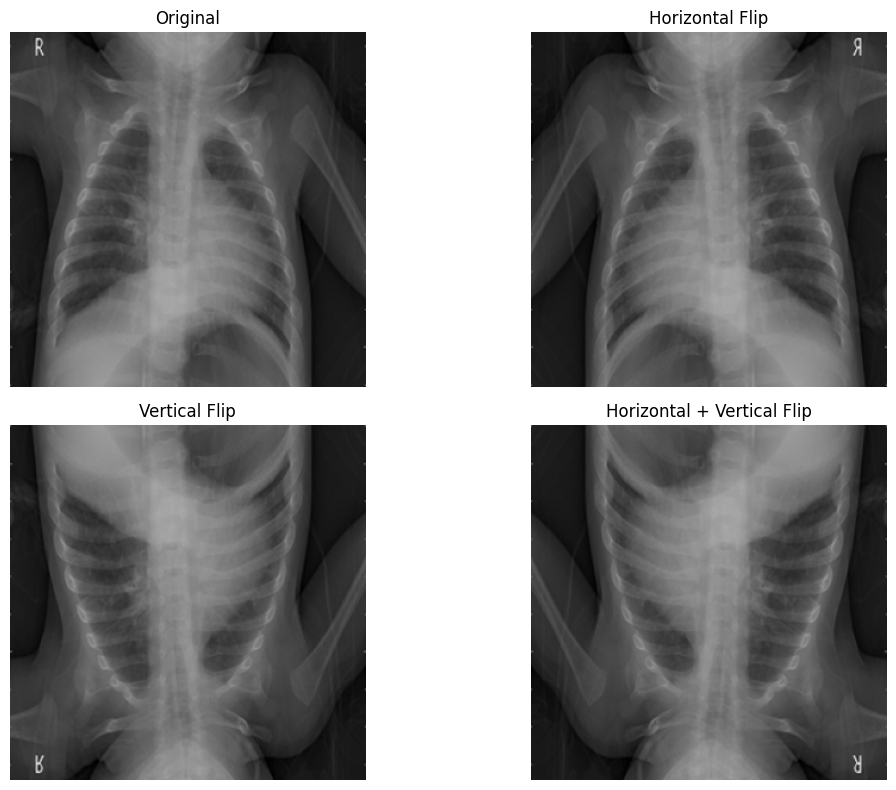

In [11]:
def apply_flipping(image_path):

    # Load image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Apply flipping
    flip_h = cv2.flip(image, 1)   # Horizontal
    flip_v = cv2.flip(image, 0)   # Vertical
    flip_both = cv2.flip(image, -1)  # Both

    return image, flip_h, flip_v, flip_both

# Select a sample image
image_folder = "/content/drive/MyDrive/Colab Notebooks/COVID-19_Radiography_Dataset/Viral Pneumonia/images"
sample_image = random.choice(os.listdir(image_folder))
image_path = os.path.join(image_folder, sample_image)

# Apply flipping
original, h_flip, v_flip, both_flip = apply_flipping(image_path)

# Plot the results
titles = ["Original", "Horizontal Flip", "Vertical Flip", "Horizontal + Vertical Flip"]
images = [original, h_flip, v_flip, both_flip]

plt.figure(figsize=(12, 8))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(images[i])
    plt.title(titles[i])
    plt.axis("off")

plt.tight_layout()
plt.savefig("flipping_augmentation.png", dpi=300, bbox_inches="tight")
plt.show()

**Step-3 Contrast Adjustment**

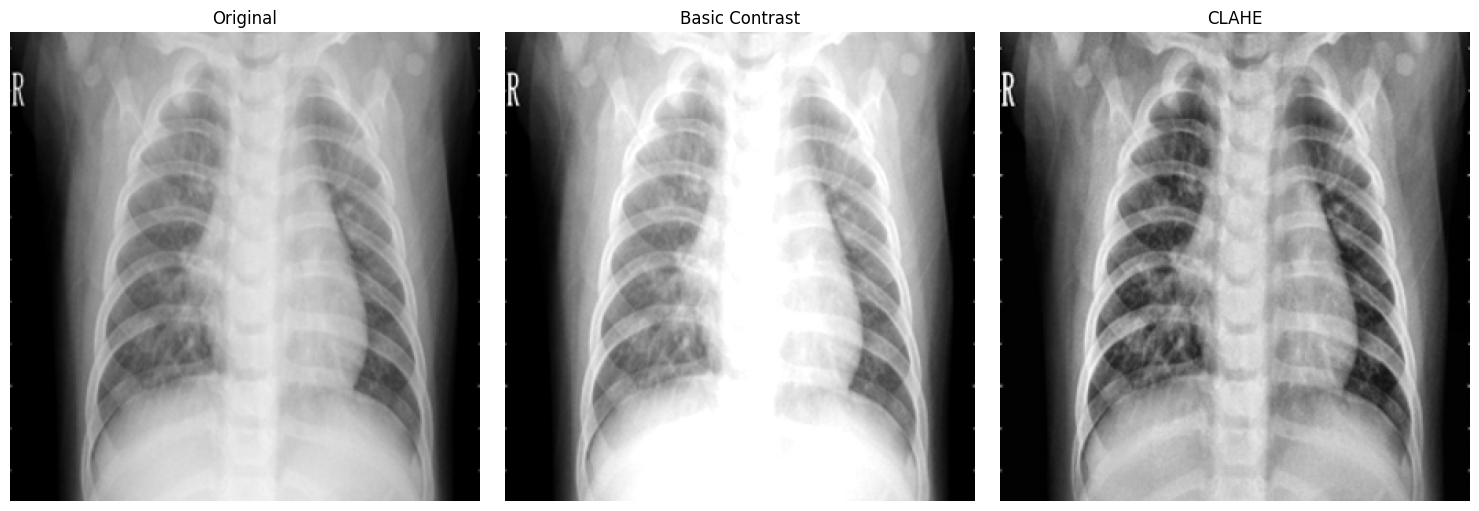

In [12]:
def contrast_adjustments(image_path):

    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Basic contrast scaling
    alpha = 1.5  # Contrast control (1.0-3.0)
    beta = 0     # Brightness control (0-100)
    basic_contrast_img = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

    # CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_img = clahe.apply(image)

    return image, basic_contrast_img, clahe_img

# Pick a random image from dataset
image_folder = "/content/drive/MyDrive/Colab Notebooks/COVID-19_Radiography_Dataset/Viral Pneumonia/images"
sample_image = random.choice(os.listdir(image_folder))
image_path = os.path.join(image_folder, sample_image)

# Apply contrast methods
original, contrast_scaled, clahe_result = contrast_adjustments(image_path)

# Plot
titles = ["Original", "Basic Contrast", "CLAHE"]
images = [original, contrast_scaled, clahe_result]

plt.figure(figsize=(15, 5))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis("off")

plt.tight_layout()
plt.savefig("contrast_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

**Step-4 Zooming & Cropping Augmentation**


*  Creates synthetic examples where the chest X-ray is zoomed in slightly and cropped.



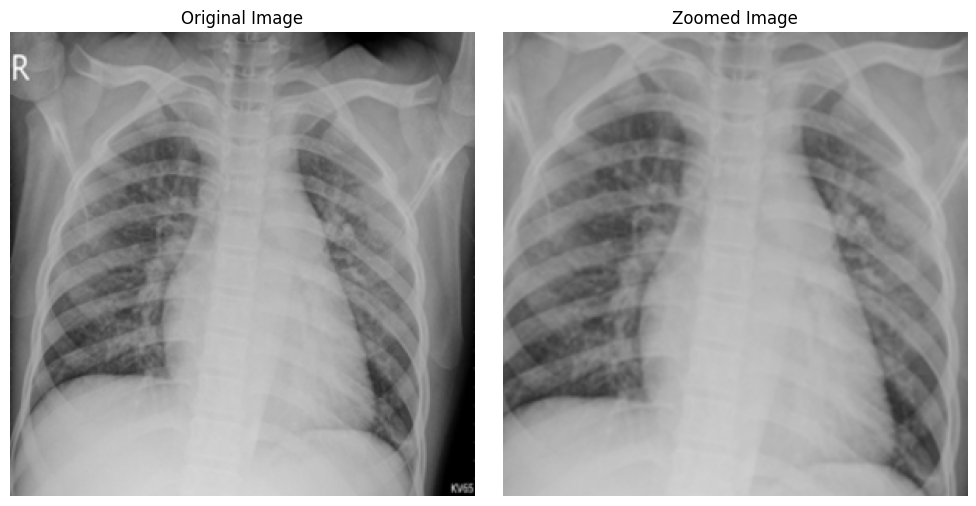

In [13]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import random

def apply_zoom_crop(image_path, zoom_factor=1.2):

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w = image.shape[:2]

    # Calculate cropping boundaries
    new_h, new_w = int(h / zoom_factor), int(w / zoom_factor)
    start_h, start_w = (h - new_h) // 2, (w - new_w) // 2
    cropped_img = image[start_h:start_h+new_h, start_w:start_w+new_w]

    # Resize back to original size
    zoomed_img = cv2.resize(cropped_img, (w, h), interpolation=cv2.INTER_LINEAR)

    return image, zoomed_img

# Random image from dataset
image_folder = "/content/drive/MyDrive/Colab Notebooks/COVID-19_Radiography_Dataset/Viral Pneumonia/images"
sample_image = random.choice(os.listdir(image_folder))
image_path = os.path.join(image_folder, sample_image)

# Apply zoom
original, zoomed = apply_zoom_crop(image_path)

# Plot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(zoomed)
plt.title("Zoomed Image")
plt.axis("off")

plt.tight_layout()
plt.savefig("zoomed_augmentation.png", dpi=300, bbox_inches="tight")
plt.show()


**Step-5 Noise & Blur Augmentation**

*       Applies Gaussian blur and noise to an image.



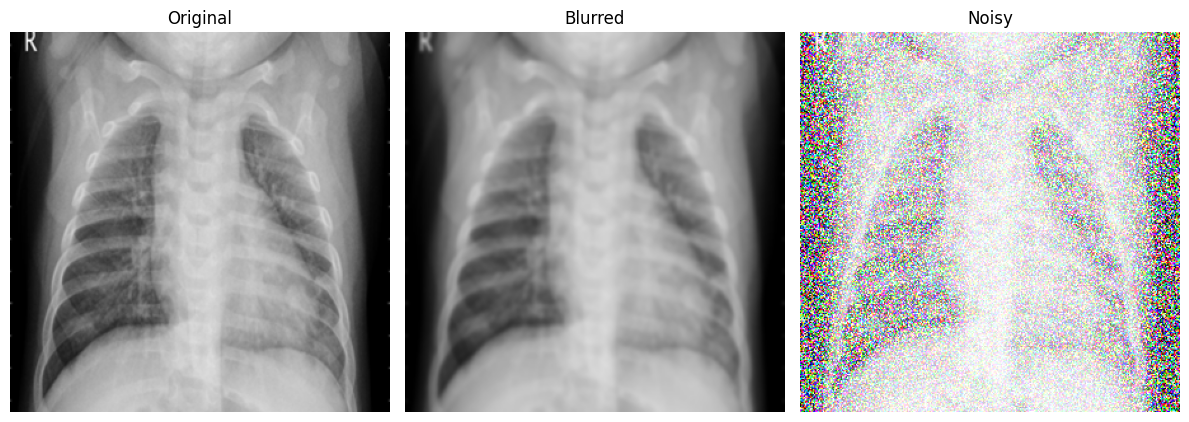

In [14]:
def apply_noise_blur(image_path):
    """
    Applies Gaussian blur and noise to an image.
    """
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Apply Gaussian Blur
    blurred = cv2.GaussianBlur(image, (7, 7), 0)

    # Add Gaussian Noise
    noise = np.random.normal(0, 25, image.shape).astype(np.uint8)
    noisy = cv2.add(image, noise)

    return image, blurred, noisy

# Pick a random image
image_folder = "/content/drive/MyDrive/Colab Notebooks/COVID-19_Radiography_Dataset/Viral Pneumonia/images"
sample_image = random.choice(os.listdir(image_folder))
image_path = os.path.join(image_folder, sample_image)

# Apply augmentations
original, blurred_img, noisy_img = apply_noise_blur(image_path)

# Plot results
titles = ["Original", "Blurred", "Noisy"]
images = [original, blurred_img, noisy_img]

plt.figure(figsize=(12, 5))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(images[i])
    plt.title(titles[i])
    plt.axis("off")

plt.tight_layout()
plt.savefig("noise_blur_comparison.png", dpi=300, bbox_inches="tight")
plt.show()


**Final Augmentation Function**

*   Below is a clean, reusable data augmentation function that combines all the approved augmentation techniques



In [15]:
def apply_augmentations_with_label(image):
    applied = []

    # --- Rotation ---
    angle = random.uniform(-15, 15)
    applied.append(f"Rotated({angle:.1f}°)")
    h, w = image.shape[:2]
    M = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1.0)
    image = cv2.warpAffine(image, M, (w, h))

    # --- Horizontal Flip ---
    if random.random() > 0.5:
        image = cv2.flip(image, 1)
        applied.append("Flipped")

    # --- CLAHE Contrast ---
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    image = clahe.apply(gray)
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    applied.append("CLAHE")

    # --- Zoom + Crop ---
    zoom_factor = 1.2
    zh, zw = int(h / zoom_factor), int(w / zoom_factor)
    start_h, start_w = (h - zh) // 2, (w - zw) // 2
    image = image[start_h:start_h+zh, start_w:start_w+zw]
    image = cv2.resize(image, (w, h))
    applied.append("Zoom")

    # --- Gaussian Blur (Optional) ---
    if random.random() > 0.7:
        image = cv2.GaussianBlur(image, (5, 5), 0)
        applied.append("Blur")

    return image, " + ".join(applied)


**Apply Augmentation Function to a Batch & Visualize Samples**

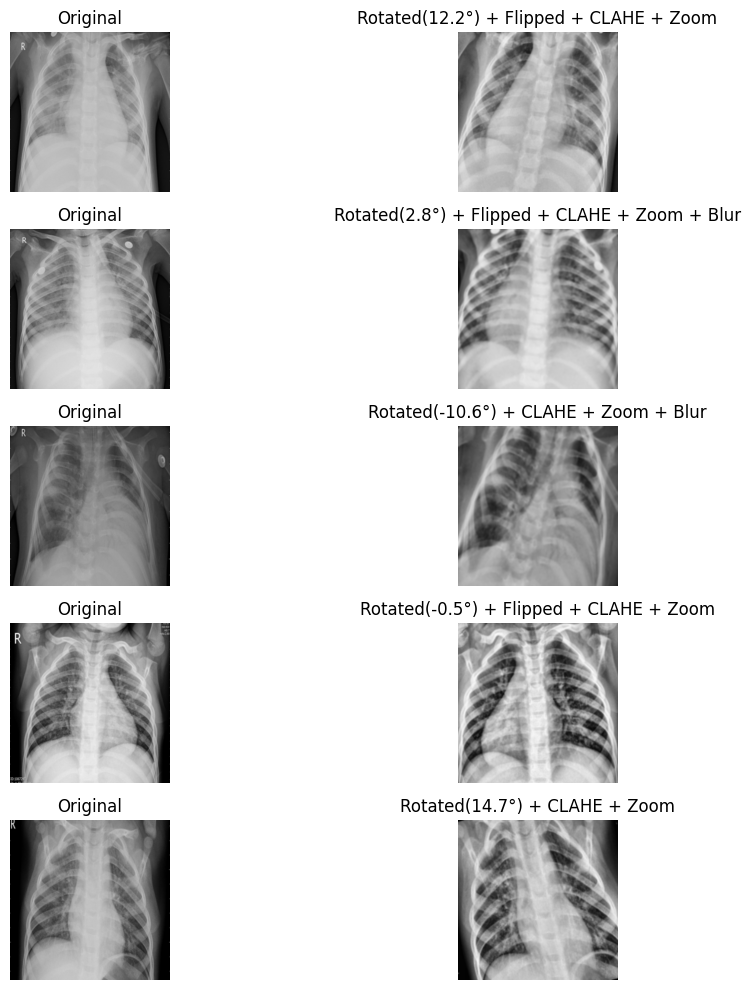

In [16]:
def load_images_from_folder(folder_path, count=5):
    """
    Loads a small batch of RGB images from a folder.
    """
    image_files = random.sample(os.listdir(folder_path), count)
    images = []
    for file in image_files:
        img_path = os.path.join(folder_path, file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append((file, img))
    return images

def visualize_augmented_batch_with_labels(folder_path, sample_size=5):
    batch = load_images_from_folder(folder_path, count=sample_size)

    plt.figure(figsize=(12, 2 * sample_size))
    for i, (filename, img) in enumerate(batch):
        aug_img, label = apply_augmentations_with_label(img)

        # Original
        plt.subplot(sample_size, 2, 2 * i + 1)
        plt.imshow(img)
        plt.title("Original")
        plt.axis("off")

        # Augmented with applied label
        plt.subplot(sample_size, 2, 2 * i + 2)
        plt.imshow(aug_img)
        plt.title(label)
        plt.axis("off")

    plt.tight_layout()
    plt.savefig("labeled_augmented_batch.png", dpi=300, bbox_inches="tight")
    plt.show()


category_path = "/content/drive/MyDrive/Colab Notebooks/COVID-19_Radiography_Dataset/Viral Pneumonia/images"

# Run the visualizer
visualize_augmented_batch_with_labels(category_path, sample_size=5)


## **Augmented images Pipeline**

*   Generate and save augmented images for the underrepresented classes so we can match them to ~10,000 samples each.



In [19]:
def augment_and_save_images(input_dir, output_dir, target_count, augment_fn):
    """
    Generates and saves augmented images until target_count is reached.

    Parameters:
    - input_dir: folder with original images
    - output_dir: where augmented images will be saved
    - target_count: desired total number of images (original + augmented)
    - augment_fn: function to apply augmentations
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    image_files = [f for f in os.listdir(input_dir) if f.endswith(('.png', '.jpg'))]
    current_count = len(os.listdir(output_dir))
    print(f"Original image count: {current_count}")

    if current_count >= target_count:
        print("No augmentation needed. Already at or above target.")
        return

    num_to_generate = target_count - current_count
    print(f"Generating {num_to_generate} augmented images...")

    i = 0
    while i < num_to_generate:
        img_name = random.choice(image_files)
        img_path = os.path.join(input_dir, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        # Apply your custom augmentation pipeline
        aug_img = augment_fn(img)

        save_path = os.path.join(output_dir, f"aug_{i}_{img_name}")
        cv2.imwrite(save_path, aug_img)
        i += 1

    print(f"✅ Augmentation complete. Total saved: {num_to_generate} images.")

**Augmented Viral Penumonia Images**

In [21]:
import os

def custom_augment_pipeline(img):
    # Rotate + CLAHE + Zoom (as tested)
    angle = random.uniform(-12, 12)
    h, w = img.shape[:2]

    # Rotation
    M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1)
    img = cv2.warpAffine(img, M, (w, h))

    # CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)

    # Zoom
    zoom_factor = 1.1
    zh, zw = int(h / zoom_factor), int(w / zoom_factor)
    top = (h - zh) // 2
    left = (w - zw) // 2
    img = img[top:top+zh, left:left+zw]
    img = cv2.resize(img, (w, h))

    return img

# === Configuration ===
input_folder = "/content/drive/MyDrive/Colab Notebooks/COVID-19_Radiography_Dataset/Viral Pneumonia/images"
output_folder = "/content/drive/MyDrive/Colab Notebooks/Augmented/Viral Pneumonia"
target_total = 2500

# === Check if augmentation is needed ===
current_count = len(os.listdir(output_folder)) if os.path.exists(output_folder) else 0

if current_count >= target_total:
    print(f"✅ Skipping augmentation. {current_count} images already exist in '{output_folder}'.")
else:
    print(f"🛠️  Current count: {current_count}. Starting augmentation to reach {target_total} images...")
    augment_and_save_images(input_folder, output_folder, target_total, custom_augment_pipeline)


✅ Skipping augmentation. 2500 images already exist in '/content/drive/MyDrive/Colab Notebooks/Augmented/Viral Pneumonia'.


**Augmented Covid Images**

In [23]:
# === Configuration for COVID ===
input_folder = "/content/drive/MyDrive/Colab Notebooks/COVID-19_Radiography_Dataset/COVID/images"
output_folder = "/content/drive/MyDrive/Colab Notebooks/Augmented/COVID"
target_total = 2500

# === Check if augmentation is needed ===
current_count = len(os.listdir(output_folder)) if os.path.exists(output_folder) else 0

if current_count >= target_total:
    print(f"✅ Skipping augmentation. {current_count} images already exist in '{output_folder}'.")
else:
    print(f"🛠️  Current count: {current_count}. Starting augmentation to reach {target_total} images...")
    augment_and_save_images(input_folder, output_folder, target_total, custom_augment_pipeline)


✅ Skipping augmentation. 2500 images already exist in '/content/drive/MyDrive/Colab Notebooks/Augmented/COVID'.


**Augmented Lung Opacity Images**

In [24]:
# === Configuration for Lung Opacity ===
input_folder = "/content/drive/MyDrive/Colab Notebooks/COVID-19_Radiography_Dataset/Lung_Opacity/images"
output_folder = "/content/drive/MyDrive/Colab Notebooks/Augmented/Lung_Opacity"
target_total = 2500

# === Check if augmentation is needed ===
current_count = len(os.listdir(output_folder)) if os.path.exists(output_folder) else 0

if current_count >= target_total:
    print(f"✅ Skipping augmentation. {current_count} images already exist in '{output_folder}'.")
else:
    print(f"🛠️  Current count: {current_count}. Starting augmentation to reach {target_total} images...")
    augment_and_save_images(input_folder, output_folder, target_total, custom_augment_pipeline)


🛠️  Current count: 0. Starting augmentation to reach 2500 images...
Original image count: 0
Generating 2500 augmented images...
✅ Augmentation complete. Total saved: 2500 images.


# **Count & Plot Final Class Distribution**

COVID: 2500 images
Viral Pneumonia: 2500 images
Lung_Opacity: 2500 images


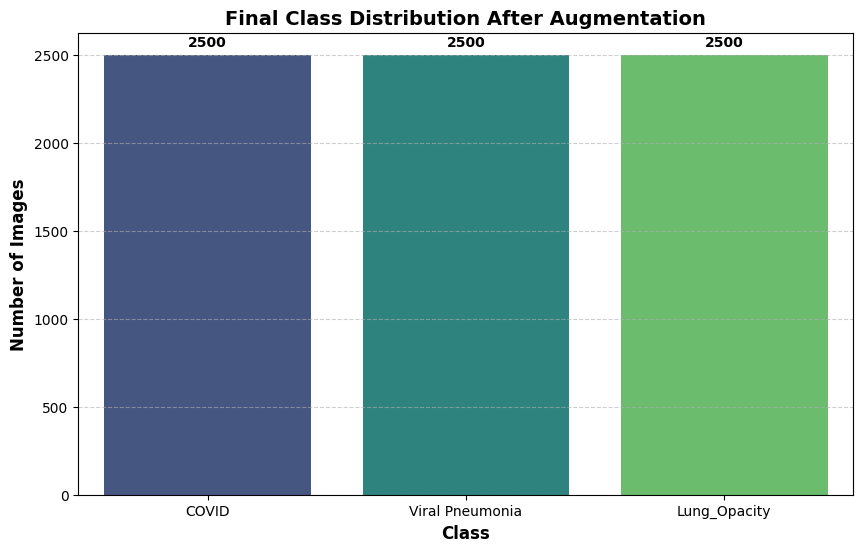

In [28]:
# Path to augmented dataset
augmented_path = "/content/drive/MyDrive/Colab Notebooks/Augmented"
categories = ["COVID", "Viral Pneumonia", "Lung_Opacity"]

# Count images in each folder
image_counts = {}
for category in categories:
    class_path = os.path.join(augmented_path, category)
    count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg'))])
    image_counts[category] = count
    print(f"{category}: {count} images")

# Plotting
def plot_augmented_distribution(counts_dict, save_path="augmented_distribution_plot.png"):
    categories = list(counts_dict.keys())
    counts = list(counts_dict.values())

    plt.figure(figsize=(10, 6))
    sns.barplot(x=categories, y=counts, hue=categories, palette="viridis", legend=False)

    for i, count in enumerate(counts):
        plt.text(i, count + 50, str(count), ha='center', fontweight='bold')

    plt.title("Final Class Distribution After Augmentation", fontsize=14, fontweight='bold')
    plt.xlabel("Class", fontsize=12, fontweight='bold')
    plt.ylabel("Number of Images", fontsize=12, fontweight='bold')
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

# Call the function to plot
plot_augmented_distribution(image_counts)
